<a href="https://colab.research.google.com/github/patrickjbuckley01/HepatocellularCarcinoma/blob/master/Cancer_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import os
import PIL.Image
import pandas as pd
# load dataset
x1 = []
x2 = []
y = []
p = Path('/content/drive/MyDrive/COMP4550/Project')
for i in p.iterdir():
    if i.is_dir() and not i.__str__().__contains__('checkpoints'):
        patient = i
        outcome_file = open(i.__str__()+'/Dict.txt','r')
        outcome_line = outcome_file.readline()
        outcomes = {}
        while outcome_line != "":
          outcome = outcome_line.split(",")
          if len(outcome[0]) == 4:
            outcome[0] = '/'+outcome[0]
          outcomes[outcome[0]] = outcome[1]
          outcome_line = outcome_file.readline()
        temp_p = Path(i.__str__())
        fold = 0
        for j in temp_p.iterdir():
            if j.is_dir():
                scan_p = Path(j.__str__())
                temp_scan = []
                temp_y = []
                for k in scan_p.iterdir():
                    temp_scan.append(k.__str__())
                    if k.__str__()[-9:-4] in outcomes:
                      temp_y.append(outcomes[k.__str__()[-9:-4]][0])
                    else:
                      temp_y.append('2')
                if fold == 0:
                  x1.append(temp_scan)
                  y.append(temp_y)
                  fold = 1
                else:
                  x2.append(temp_scan)

In [ ]:
! pip install tensorflow_io[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 29.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.32.0
    Uninstalling tensorflow-io-gcs-filesystem-0.32.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.32.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: ten

In [ ]:
import tensorflow
from numpy import asarray
from numpy import unique
from numpy import argmax
from tensorflow.math import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras import Input
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dec_x = []
dec_x1 = []
dec_x2 = []
dec_y = []
for i in range(len(x1)):
  temp_x = []
  temp_y
  for j in range(len(x1[i])):
    image_bytes1 = tensorflow.io.read_file(x1[i][j])
    image1 = tfio.image.decode_dicom_image(image_bytes1, dtype=tensorflow.float32)
    image_bytes2 = tensorflow.io.read_file(x2[i][j])
    image2 = tfio.image.decode_dicom_image(image_bytes2, dtype=tensorflow.float32)
    comb_image = []
    for k in range(len(image1)):
      comb_image.append([image1[k], image2[k]])
    dec_x.append(comb_image)
    #dec_x1.append([image1])
    #dec_x2.append([image2])

for i in y:
  for j in range(len(i)):
    if i[j] == '0':
      dec_y.append([1,0,0])
    elif i[j] == '1':
      dec_y.append([0,1,0])
    else:
      dec_y.append([0,0,1])

dfx = np.asarray(dec_x)
#dfx1 = np.asarray(dec_x1)
#dfx2 = np.asarray(dec_x2)
dfy = np.asarray(dec_y)

# separate data into train and test sets
# x_train, x_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2)

kfold = KFold(shuffle=True, random_state=1)

In [ ]:
for train, test in kfold.split(dfx):
  print(train)
  print(test)

In [ ]:
loss = []
val_loss = []
#fold = next(kfold.split(dfx2))
#fold = next(kfold.split(dfx))
#fold = next(kfold.split(dfx1))
#fold = next(kfold.split(dfx1))
#fold = next(kfold.split(dfx1))
train = fold[0]
test = fold[1]
for i in range(1):#kfold.split(dfx):
  # reshape data to have a single channel
  x_train = dfx[train]
  x_test = dfx[test]
  y_train = dfy[train]
  y_test = dfy[test]
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[3], x_train.shape[4], 2))
  x_test = x_test.reshape((x_test.shape[0], x_test.shape[3], x_test.shape[4], 2))

  # determine the shape of the input images
  in_shape = x_train.shape[1:]

  # determine the number of classes
  n_classes = 3

  # normalize pixel values
  x_train = x_train.astype('float32') / 255.0
  x_test = x_test.astype('float32') / 255.0

  # define model
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  #model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  #model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  # define loss and optimizer
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # fit the model
  history = model.fit(x_train, y_train, epochs=20, batch_size=4, verbose=0, validation_split=0.3)

  # evaluate the model
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  print('Accuracy: %.3f' % acc)

Accuracy: 0.984


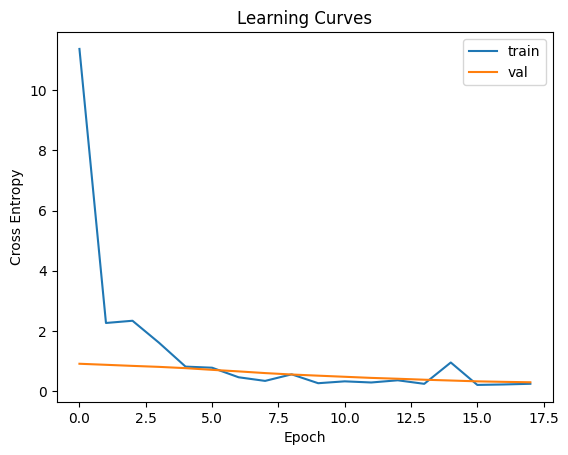

[6787.28076171875, 109.1678237915039, 11.366291999816895, 2.2668819427490234, 2.340799570083618, 1.6104990243911743, 0.8178853988647461, 0.7816201448440552, 0.46421554684638977, 0.34389403462409973, 0.561482846736908, 0.2668834328651428, 0.32902732491493225, 0.2910735011100769, 0.3638449013233185, 0.24661129713058472, 0.955014705657959, 0.21020390093326569, 0.22551310062408447, 0.24792014062404633] [0.0, 0.9496320486068726, 0.9129236340522766, 0.8781178593635559, 0.8423570394515991, 0.8096234798431396, 0.76691073179245, 0.7111592292785645, 0.6594776511192322, 0.6032269597053528, 0.5561601519584656, 0.5174652934074402, 0.4805382490158081, 0.44361644983291626, 0.41517436504364014, 0.3831471800804138, 0.3564528524875641, 0.32884252071380615, 0.31213024258613586, 0.2982024848461151]


In [ ]:
from matplotlib import pyplot
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'][2:], label='train')
pyplot.plot(history.history['val_loss'][2:], label='val')
pyplot.legend()
pyplot.show()
print(history.history['loss'], history.history['val_loss'])

In [ ]:
pred = dfx.astype('float32') / 255.0
pred = pred.reshape((pred.shape[0], pred.shape[3], pred.shape[4], 2))
y_predict = model.predict(pred)
y_true = dfy
y_predicta = []
y_truea = []
for i in range(len(pred)):
  y_predicta.append(tf.argmax(y_predict[i]))
  y_truea.append(tf.argmax(y_true[i]))


10/10 [==============================] - 32s 3s/step


In [ ]:
y_predict = tf.constant(np.array(y_predicta))
y_true = tf.constant(np.array(y_truea))
res = confusion_matrix(y_true, y_predict)
actual = confusion_matrix(y_true, y_true)
print(res)
print(len(x_test))
print(actual)

tf.Tensor(
[[  9   0   7]
 [  0  64   0]
 [  0   0 227]], shape=(3, 3), dtype=int32)
62
tf.Tensor(
[[ 16   0   0]
 [  0  64   0]
 [  0   0 227]], shape=(3, 3), dtype=int32)


In [ ]:
print(pred.shape)

(307, 512, 512, 2)


In [ ]:
# make a prediction
image = x_train[0]
yhat = model.predict(asarray([image]))
print('Predicted: class=%d' % argmax(yhat))

1/1 [==============================] - 0s 274ms/step
Predicted: class=1


In [ ]:
test_path = '/content/drive/MyDrive/COMP4550/Project/TCGA-BC-A3KF/Scan1/1-20.dcm'
test_image_bytes = tensorflow.io.read_file(test_path)
test_image = tfio.image.decode_dicom_image(image_bytes, dtype=tensorflow.float32)
test_norm_image = test_image / 255.0
print(test_norm_image.shape)
test_predict = model.predict(test_norm_image)
print('Predicted: class=%d' % argmax(test_predict))

(1, 512, 512, 1)
1/1 [==============================] - 0s 168ms/step
Predicted: class=1
